# Отток клиентов

На основе исторических данных о поведении клиентов и расторжении договоров с банком, необходимо спрогнозировать, уйдет ли клиент из банка в ближайшее время или нет. Необходимо обеспечить значение F1-меры не менее 0.59.

### Шаг 1. Подготовка данных

Для начала импортируем все библиотеки, потребующиеся в данной работе.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix

Далее прочитаем файл с данными и изучим общую информацию.

In [2]:
# Путь к файлу на локальком компьютере
path = 'datasets/Churn.csv'
# Путь к файлу в интернете
path_net = 'is_hidden'
# Пробуем прочитать локальный файл
try:
    data = pd.read_csv(path)                                   
# Если не получилось - читаем из интернета
except:
    data = pd.read_csv(path_net)
# Получаем основную информацию о файле
data.info()                                                    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Выведем часть данных.

In [3]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Пропуски есть только в столбце Tenure. На первый взгляд данные выглядят нормально. Избавимся от признаков, которые никак не повлияют на целевой признак: номер строки, Id клиента, фамилия. Но перед этим проверим данные признаки на дубликаты.

In [4]:
columns = ['RowNumber', 'CustomerId', 'Surname']
for column in columns:
    print('Количество дубликатов в столбце {} = {}'.format(column, data[column].duplicated().sum()))

Количество дубликатов в столбце RowNumber = 0
Количество дубликатов в столбце CustomerId = 0
Количество дубликатов в столбце Surname = 7068


Дубликаты в столбце Surname не важны, т.к. фамилия может повторяться. Важнее то, что нет дубликатов в столбце CustomerId, что говорит о том, что клиенты с одинаковыми фамилиями имеют разный Id, а значит являются разными клиентами. Удаляем эти признаки из данных, исследуем оставшиеся на артефакты.

In [5]:
# Удалим ненужные признаки
data_clean = data.drop(columns, axis=1)
# Изучим числовые данные
data_clean.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
print(data_clean.Geography.value_counts())
print(data_clean.Gender.value_counts())

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64
Male      5457
Female    4543
Name: Gender, dtype: int64


Никаких артефактов не обнаружено. Необходимо разобраться с пропусками в столбце Tenure.

In [7]:
print('Количество нулевых значений = ', data_clean['Tenure'].isna().sum())
print('Доля нулевых значений = ', data_clean['Tenure'].isna().sum() / len(data_clean))

Количество нулевых значений =  909
Доля нулевых значений =  0.0909


9% - это много. Просто удалить строки с нулевыми значениями будет слишком расточительно. Попробуем найти связь с другими признаками.

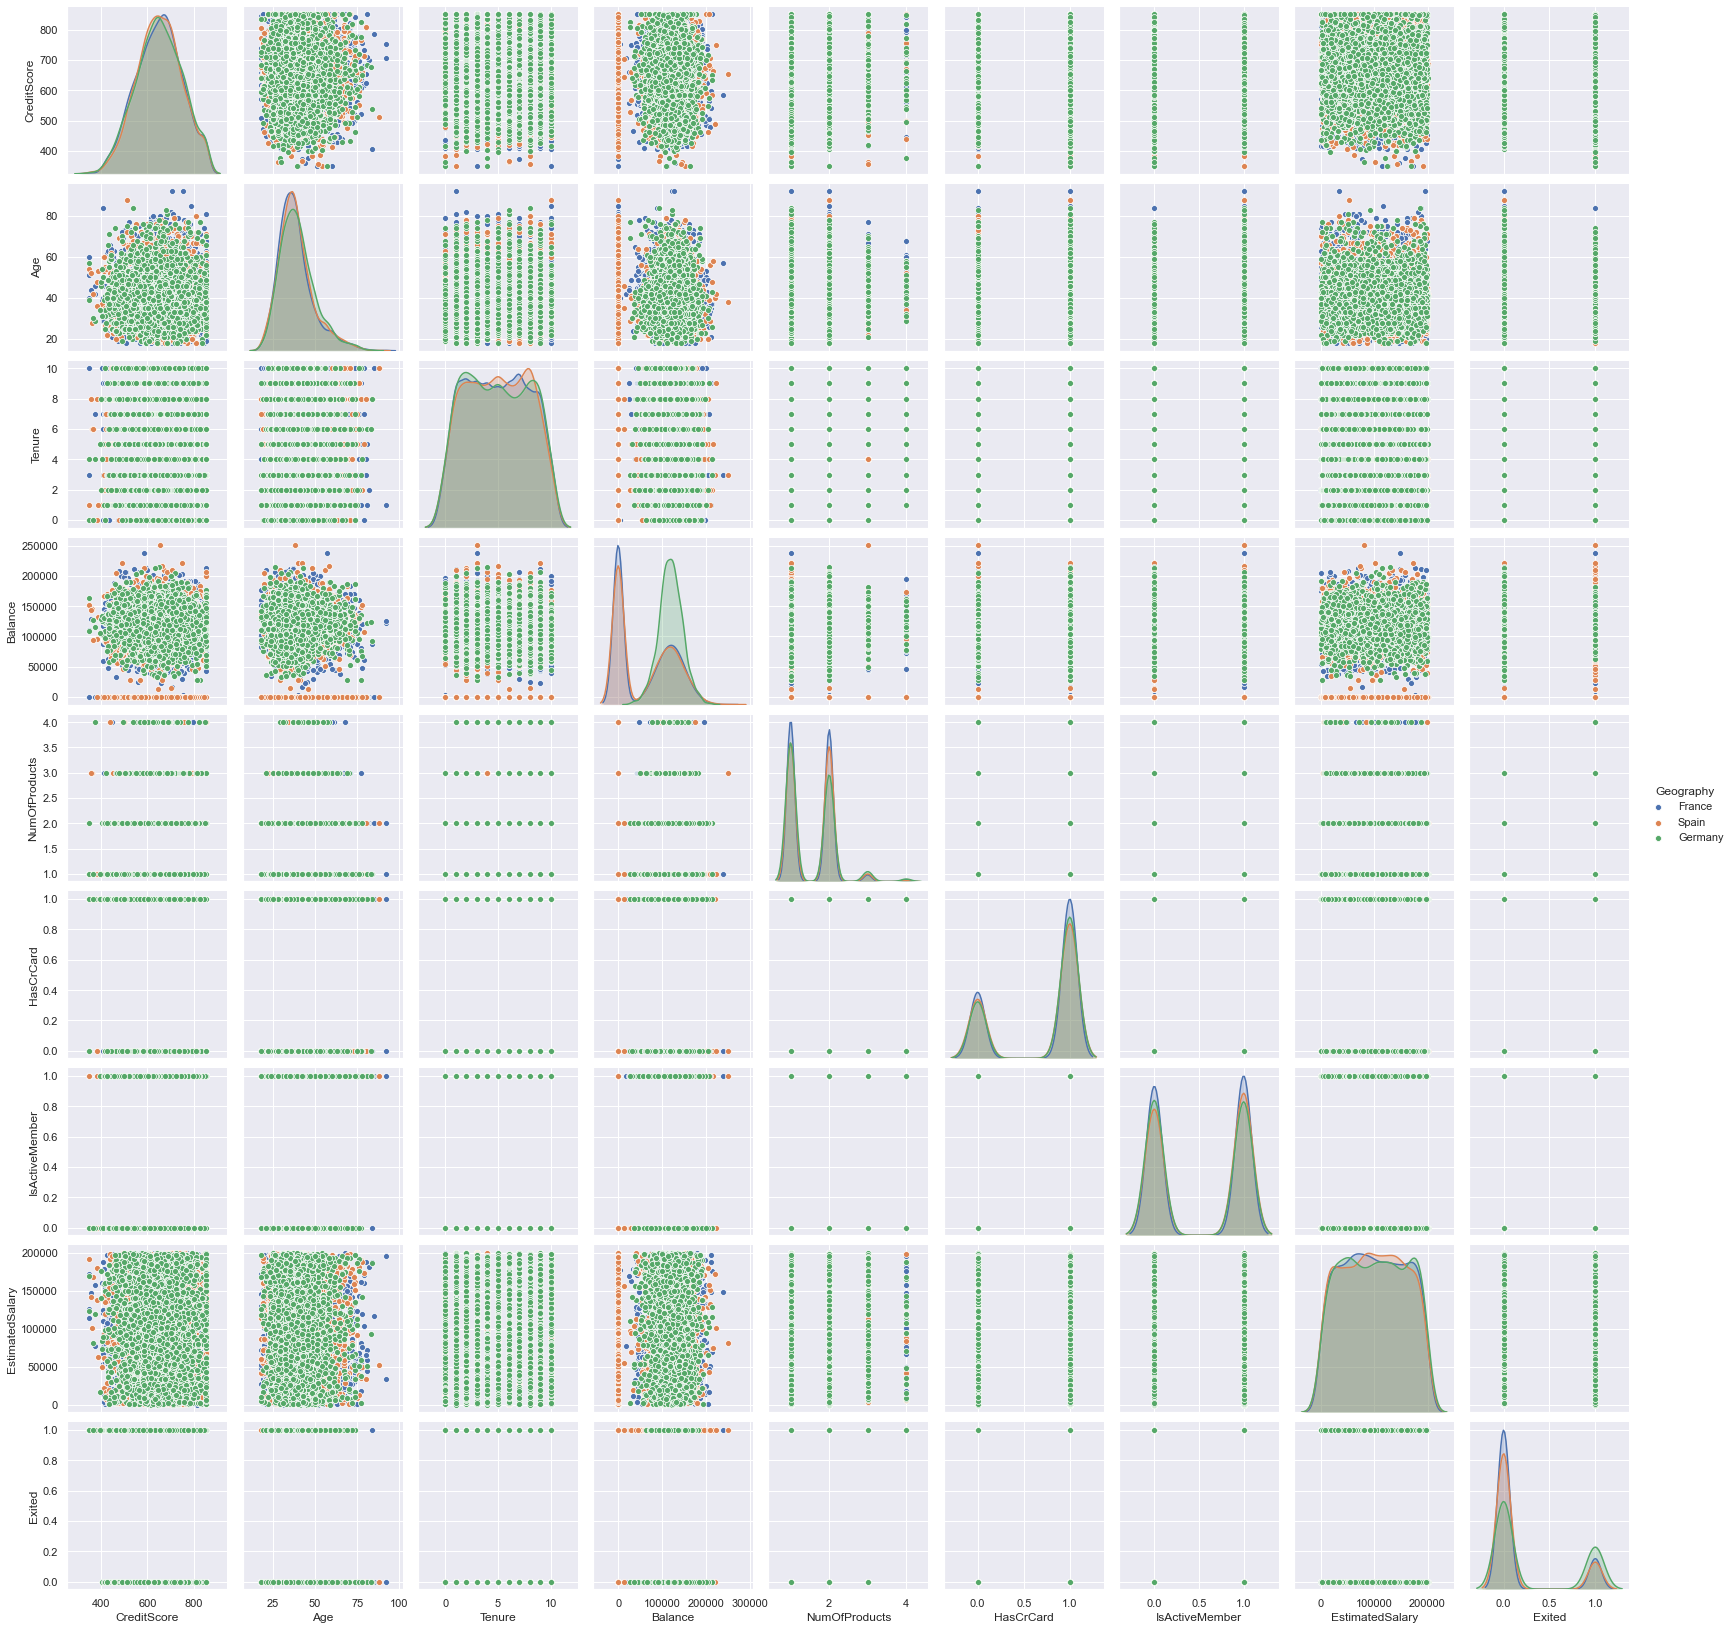

In [8]:
sns.set()
sns.pairplot(data=data_clean, hue='Geography')
plt.show()

Никаких явных зависимостей между признаком Tenure и другими признаками не выявлено. Как уже было сказано выше, удалив строки с пропусками - потеряем 9% данных. Не заполнить пропуски тоже не получится, т.к. некоторые алгоритмы требуют отсутствия пропусков. Значит необходимо заполнить пропуски. Так как никаких зависимостей не выявлено, можно заполнить либо средним значением, либо резко отличающимся от других. Заменить просто средним - можем сильно исказить результаты. Если заменим значением, резко отличающимся от других - затем придется каждый раз фильтровать данные по этому значению, что впринципе аналогично удалению строк с отсутствующими данными. Остается один вариант: предположим, что если данные о количестве недвижимости не указаны, значит недвижимости у клиента нет. На основе этого предположения заполним пропуски нулевыми значениями.

In [9]:
data_clean['Tenure'] = data_clean['Tenure'].fillna(0)
data_clean['Tenure'].describe()

count    10000.000000
mean         4.543400
std          3.111573
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         10.000000
Name: Tenure, dtype: float64

Можно заметить, что такая замена не сильно исказила исходные данные. Также поменяем тип данных в этом столбце на int.

In [10]:
data_clean['Tenure'] = data_clean['Tenure'].astype(int)

Последнее, что необходимо сделать, прежде чем приступать к моделированию - подготовить признаки. Категориальные признаки преобразуем методом прямого кодирования (OHE), количественные - отмасштабируем.

In [11]:
# OHE для категориальных признаков
data_ohe = pd.get_dummies(data_clean, drop_first=True)

# Отделим целевой признак от остальных признаков
features = data_ohe.drop('Exited', axis=1)
target = data_ohe['Exited']

# Выделим числовые признаки
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Отмасштабируем числовые признаки
scaler = StandardScaler()
scaler.fit(features[numeric])
features[numeric] = scaler.transform(features[numeric])

### Вывод

Исходные данные были изучены и предобработанны:
1. Удалены признаки, не влияющие на целевой признак;
2. Отсутствующие значения в столбце Tenure заменены на нулевые, тип данных столбца заменен на int;
3. Данные разделены на признаки и целевой признак;
4. Категориальные признаки обработаны техникой прямого кодирования;
5. Количественные признаки приведены к единому масштабу;

<br>Теперь можно переходить к следующему шагу.

### Шаг 2. Исследование дисбаланса данных

Прежде, чем мы займемся исследованием, разделим данные на тренировочну, валидационную и тестовую выборку в соотношении 3:1:1.

In [12]:
features_not_test, features_test, target_not_test, target_test = train_test_split(features, target, test_size=0.2, random_state=321)
features_train, features_valid, target_train, target_valid = train_test_split(features_not_test, target_not_test, test_size=0.25, random_state=321)

Теперь оценим дисбаланс классов.

In [13]:
def disb(target):
    '''
    Функция для определения дисбаланса классов.
    Показывает распределение по классам, а также во сколько раз один класс больше другого.
    '''
    print(target.value_counts())
    print(target.value_counts()[0] / target.value_counts()[1])

disb(target_train)

0    4798
1    1202
Name: Exited, dtype: int64
3.9916805324459235


Количество элементов, равных 0, почти в 4 раза больше, чем равных 1. Это явный дисбаланс. Попробуем обучить модель логистической регрессии без учета дисбаланса.

In [14]:
model = LogisticRegression()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1 = {}, AUC = {}'.format(f1_score(target_valid, predicted_valid), roc_auc_score(target_valid, predicted_valid)))

F1 = 0.2788104089219331, AUC = 0.5747967479674797


Значение F1 очень низкое, значение AUC не намного больше, чем у случайной модели. Попробуем обучить модель с учетом дисбаланса классов.

In [15]:
model = LogisticRegression(class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1 = {}, AUC = {}'.format(f1_score(target_valid, predicted_valid), roc_auc_score(target_valid, predicted_valid)))

F1 = 0.4683882457702582, AUC = 0.6792222733548091


### Вывод
Исходные данные имеют дисбаланс классов. Если его не учитывать - значение метрик получается очень низким. Для дальнейших исследований применим метод апсемплинг для балансировки классов.

### Шаг 3. Улучшение модели
Для начала напишем функцию апсемплинга.

In [16]:
def upsample(features, target, repeat):
    '''
    Функция для изменения баланса классов путем увеличения сэмплов положительного класса.
    features - признаки.
    target - целевой признак.
    repeat - количество повторов положительного класса.
    '''
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=321)
    
    return features_upsampled, target_upsampled

Так как ранее уже было обнаружено, что количество элементов положительнго класса примерно в 4 раза ниже, чем отрицательного, применим функцию upsample с параметром repeat равным четырем.

In [17]:
features_train, target_train = upsample(features_train, target_train, 4)
disb(target_train)

1    4808
0    4798
Name: Exited, dtype: int64
0.9979201331114809


От дисбаланса избавились, можем переходить к обучению моделей.

In [18]:
model = LogisticRegression()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1 = {}, AUC = {}'.format(f1_score(target_valid, predicted_valid), roc_auc_score(target_valid, predicted_valid)))

F1 = 0.46797153024911026, AUC = 0.678907807946004


Модель логистической регрессии показала довольно низкий результат. Попробуем обучить решающее дерево. Но прежде создадим необходимые функции.

In [19]:
# Создадим функцию вывода результатов
def plotting(y, res):
    sns.relplot(x='max_depth',
                y=y,
                hue='min_samples_leaf',                
                col='criterion',
                s=100,
                data=res,
                palette=sns.color_palette("hls", 9)            
               )
    plt.show()        

# Создадим функцию получения предсказаний дерева решений или случайного леса
def predict_score(model_ind, print_score, features, target, features_test, target_test,
                  criterion, max_depth, min_samples_leaf, random_state, n_estimators=None):
    '''
    Функция обучения модели дерева решений или случайного леса
    model_ind = 0 - дерево решений, model_ind = 1 - случайный лес
    print_score - печать ли результат расчета метрики F1 и AUC-ROC    
    '''
    # Выбираем модель и присваиваем гиперпараметры
    if model_ind == 0:
        model = DecisionTreeClassifier(criterion=criterion,
                                       max_depth=max_depth,                                           
                                       min_samples_leaf=min_samples_leaf,                                           
                                       random_state=random_state
                                      )
    if model_ind == 1:
        model = RandomForestClassifier(n_estimators=n_estimators,
                                       criterion=criterion,
                                       max_depth=max_depth,                                           
                                       min_samples_leaf=min_samples_leaf,                                           
                                       random_state=random_state
                                      )
    # Обучаем модель
    model.fit(features, target)
    # Предсказываем результат
    predicted_test = model.predict(features_test)
    # Печатаем значения метрик, если необходимо
    if print_score:
        print('F1 = {}, AUC = {}'.format(f1_score(target_test, predicted_test), roc_auc_score(target_test, predicted_test)))
    # Возвращаем модель и предсказанные значения
    return model, predicted_test

# Напишем функцию перебора гиперпараметров дерева решений и случайного леса
def hyper_search(model_ind, features, target, features_test, target_test):
    '''
    Функция перебора гиперпараметров дерева решения или случайного леса
    model_ind = 0 - дерево решений, model_ind = 1 - случайный лес
    '''
    # Создаем пустой датасет результатов
    res = pd.DataFrame(columns=['max_depth', 'min_samples_leaf', 'criterion', 'f1', 'auc'])
    ind = 0
    for max_depth in range(1, 11):    
        for min_samples_leaf in range (1, 10):
            for criterion in ['gini', 'entropy']:
                # Выбираем модель и присваиваем гиперпараметры
                if model_ind == 0:
                    model, predicted_valid = predict_score(model_ind, False, features, target, features_test, target_test,
                                                           criterion, max_depth, min_samples_leaf, 321)                    
                if model_ind == 1:
                    model, predicted_valid = predict_score(model_ind, False, features, target, features_test, target_test,
                                                           criterion, max_depth, min_samples_leaf, 321, 20)
                # Добавляем результаты в датасет
                res.loc[ind] = [max_depth,
                                min_samples_leaf,
                                criterion,
                                f1_score(target_valid, predicted_valid),
                                roc_auc_score(target_valid, predicted_valid)
                                ]
                ind += 1
    # Строим графики для F1 метрики
    plotting('f1', res)
    # Строим графики для AUC-ROC метрики
    plotting('auc', res)
    # Находим максимальные значения обеих метрик
    f1_max = res.f1.max()
    auc_max = res.auc.max()
    # Выводим строчки с максимальными значениями метрик
    res1 = res.query('f1 == @f1_max or auc == @auc_max')
    return res1

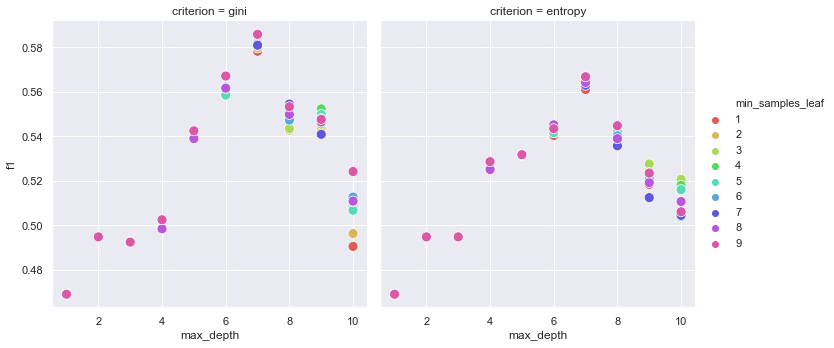

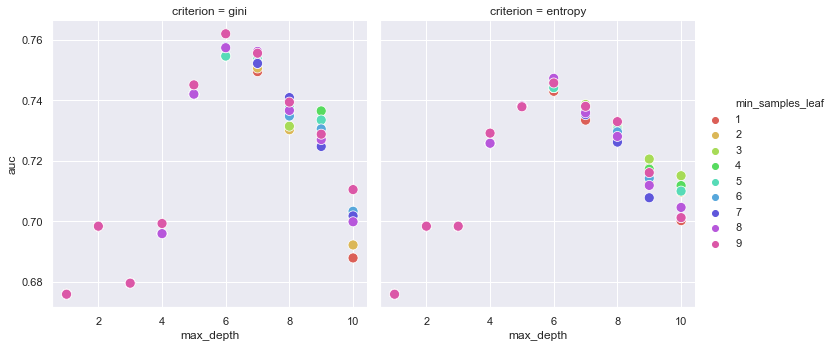

,max_depth,min_samples_leaf,criterion,f1,auc
106,6,9,gini,0.567029,0.761896
122,7,8,gini,0.585987,0.756082


In [20]:
# Обучаем дерево решений
res1 = hyper_search(0, features_train, target_train, features_valid, target_valid)
res1

Представленные зависимости показали, что максимальных значений критериев F1 и AUC-ROC можно достигнуть, используя критерий gini. Для максимизации F1 max_depth должно быть равно 7, min_samples_leaf - 8. Для максимизации AUC-ROC: max_depth=6, min_samples_leaf=9. Все представленные графики показывают, что критерии F1 и AUC-ROC ведут себя примерно одинаково при изменении гиперпараметров дерева решений.

Теперь перейдем к обучению случайного леса. n_estimators укажем равным 20. После нахождения оптимальных параметров увеличим до 100.

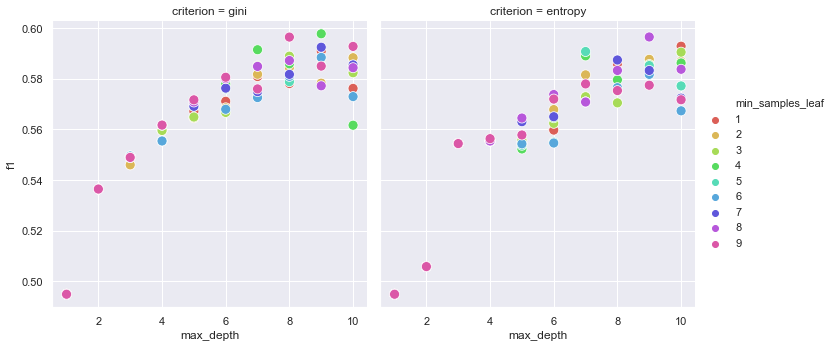

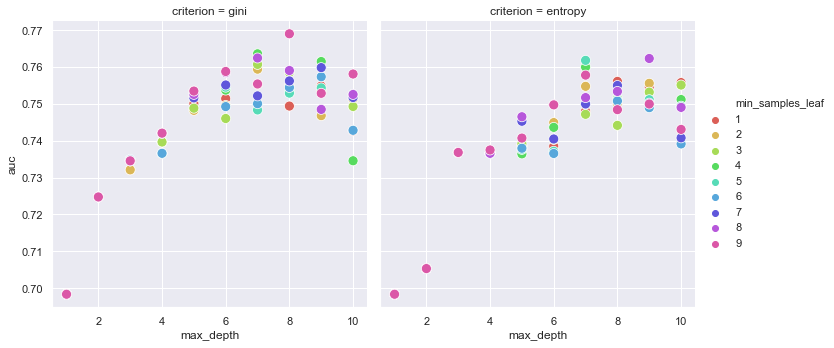

,max_depth,min_samples_leaf,criterion,f1,auc
142,8,9,gini,0.596527,0.768991
150,9,4,gini,0.597826,0.761466


In [21]:
# Обучаем случайный лес
res2 = hyper_search(1, features_train, target_train, features_valid, target_valid)
res2

Значения f1 и auc получилось немного увеличить. Обучим случайный лес с лучшими параметрами при n_estimators = 100.

In [22]:
# Обучаем модель с максимальной метрикой F1
model, predict = predict_score(1, True, features_train, target_train, features_valid, target_valid,
                               'gini', 9, 4, 321, 100)

F1 = 0.5908096280087527, AUC = 0.7556833870225496


In [23]:
# Обучаем модель с максимальной метрикой AUC-ROC
model, predict = predict_score(1, True, features_train, target_train, features_valid, target_valid,
                               'gini', 8, 9, 321, 100)

F1 = 0.5878661087866108, AUC = 0.7593495934959351


Увеличение n_estimators до 100 не привело к улучшению результата, оставим 20.

### Вывод
С учетом дисбаланса классов удалось получить модель с значением метрики F1 равным 0.598. Теперь проведем финальное тестирование.

### Шаг 4. Финальное тестирование
Проверим лучшую модель на тестовой выборке. Для этого сначала обучим модель с лучшими гиперпараметрами на не тестовой выборке (на тренировочной + валидационной), предварительно избавившись от дисбаланса.

In [24]:
disb(target_not_test)

0    6388
1    1612
Name: Exited, dtype: int64
3.9627791563275436


In [25]:
features_not_test, target_not_test = upsample(features_not_test, target_not_test, 4)
disb(target_not_test)

1    6448
0    6388
Name: Exited, dtype: int64
0.9906947890818859


In [26]:
# Обучаем модель случайного леса на всех данных, проверяем на тестовой выборке
model, predict = predict_score(1, True, features_not_test, target_not_test, features_test, target_test,
                               'gini', 9, 4, 321, 20)

F1 = 0.607645875251509, AUC = 0.770532212885154


Визуализируем результат.

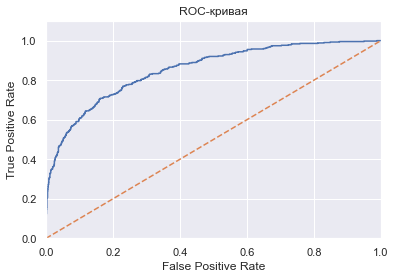

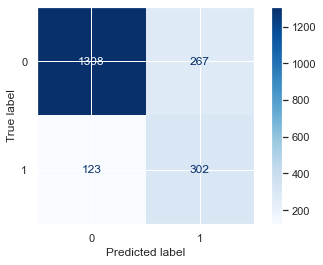

In [27]:
# Получим вероятности классов
probabilities_test = model.predict_proba(features_test)
# Выделим вероятности положительного класса
probabilities_one_test = probabilities_test[:, 1]

# Определим параметры ROC
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

# Построим ROC
plt.plot(fpr, tpr)
# ROC случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

# Установим границы осей
plt.xlim(0,1)
plt.ylim(0,1.1)
# Подпишем оси
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Добавим название
plt.title('ROC-кривая')
plt.show()

# Построим Confusion Matrix
disp = plot_confusion_matrix(model, features_test, target_test,                             
                             cmap=plt.cm.Blues
                             )
plt.show()

### Общий вывод
В ходе работы были получены следующие результаты:
1. Исходные данные предобработанны, все признаки подготовлены для моделирования
2. Получено сравнение работы логистической регрессии на дисбалансных данных и сбалансированных данных. Дисбаланс сильно ухудшает метрики
3. Проведено обучение различных моделей с различными гиперпараметрами на сбалансированных данных. Результат на валидационной выборке оказался довольно высокими. Было произведено сравнение результатов расчета метрики F1 и AUC-ROC
4. Проверена эффективность лучшей модели на тестовых данных. Значение метрики F1 равно 0.607, что выше требуемых 0,59 по заданию. Значение метрики AUC-ROC равно 0,766. Для финальной модели построена кривая ROC и Confusion Matrix.

<br> Таким образом удалось получить модель, удовлетворяющую заданным условиям.